In [2]:
# STEP 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


In [3]:
# STEP 2: Load datasets
unlabeled_data = pd.read_csv("clean_unlabeled_autoencoder.csv")
labeled_data = pd.read_csv("synthetic_iot_dataset_challenging.csv")


In [5]:
# STEP 3: Scale unlabeled data (Temperature + Humidity) for Autoencoder
scaler = MinMaxScaler()
X_unlabeled_scaled = scaler.fit_transform(unlabeled_data[["Temperature", "Humidity"]])


In [6]:
# STEP 4: Build and train autoencoder
input_dim = X_unlabeled_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="linear")(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

autoencoder.fit(X_unlabeled_scaled, X_unlabeled_scaled, epochs=50, batch_size=32, verbose=0)


In [7]:
# STEP 5: Prepare labeled data for classification
labeled_data_clean = labeled_data.drop(columns=["Device_ID"])
labels = labeled_data_clean["Anomaly"]
X_labeled = labeled_data_clean.drop(columns=["Anomaly"])


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, labels, test_size=0.2, stratify=labels, random_state=42)

In [9]:
# 3. Calculate reconstruction error SEPARATELY for train and test sets
# For training set
X_train_for_ae = X_train[["Temperature", "Humidity"]]
X_train_for_ae_scaled = scaler.transform(X_train_for_ae)
X_train_reconstructed = autoencoder.predict(X_train_for_ae_scaled)
train_reconstruction_error = np.mean((X_train_for_ae_scaled - X_train_reconstructed) ** 2, axis=1)
X_train_hybrid = X_train.copy()
X_train_hybrid["reconstruction_error"] = train_reconstruction_error

# For test set (using same scaler and autoencoder)
X_test_for_ae = X_test[["Temperature", "Humidity"]]
X_test_for_ae_scaled = scaler.transform(X_test_for_ae)
X_test_reconstructed = autoencoder.predict(X_test_for_ae_scaled)
test_reconstruction_error = np.mean((X_test_for_ae_scaled - X_test_reconstructed) ** 2, axis=1)
X_test_hybrid = X_test.copy()
X_test_hybrid["reconstruction_error"] = test_reconstruction_error


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


# STEP 7: Apply SMOTE **after** splitting
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_hybrid, y_train)


# Optional: Confirm new class balance
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

# STEP 8: Train classifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# STEP 9: Evaluate on real test data
y_pred = clf.predict(X_test_hybrid)

# STEP 10: Metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



Before SMOTE: {0: 1982, 1: 418}
After SMOTE: {0: 1982, 1: 1982}
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       496
           1       0.40      0.60      0.48       104

    accuracy                           0.78       600
   macro avg       0.65      0.70      0.67       600
weighted avg       0.82      0.78      0.79       600

[[403  93]
 [ 42  62]]


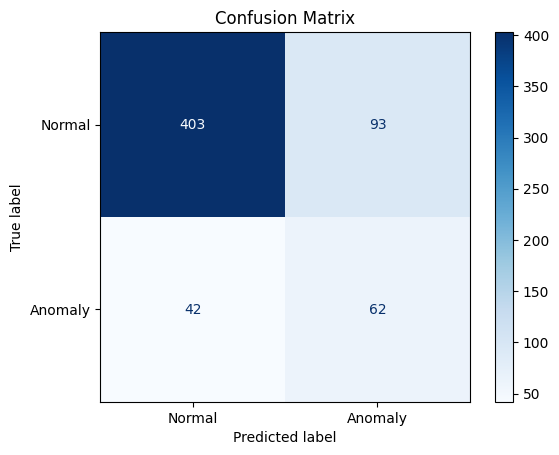

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [11]:
# Look at the reconstruction errors directly
print("Normal points reconstruction error stats:")
print(X_test_hybrid[y_test == 0]['reconstruction_error'].describe())
print("\nAnomalous points reconstruction error stats:")
print(X_test_hybrid[y_test == 1]['reconstruction_error'].describe())


Normal points reconstruction error stats:
count    496.000000
mean     371.569861
std       22.055173
min      302.657747
25%      356.699177
50%      370.633685
75%      383.507264
max      450.084891
Name: reconstruction_error, dtype: float64

Anomalous points reconstruction error stats:
count    104.000000
mean     355.462936
std       13.486626
min      326.692258
25%      348.699802
50%      353.396331
75%      358.243844
max      398.500318
Name: reconstruction_error, dtype: float64


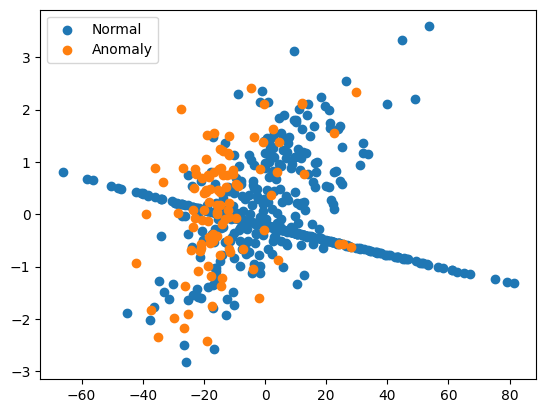

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_test_hybrid)

plt.scatter(X_vis[y_test==0, 0], X_vis[y_test==0, 1], label='Normal')
plt.scatter(X_vis[y_test==1, 0], X_vis[y_test==1, 1], label='Anomaly')
plt.legend()
plt.show()

In [13]:
print(labels.value_counts(normalize=True))


Anomaly
0    0.826
1    0.174
Name: proportion, dtype: float64


diae alaoui, malak errifai, abdellahi beddi.
we tried to use everything in the workshop but something were not relevent to our project so we tried them and deleted them.

<Axes: xlabel='Anomaly', ylabel='reconstruction_error'>

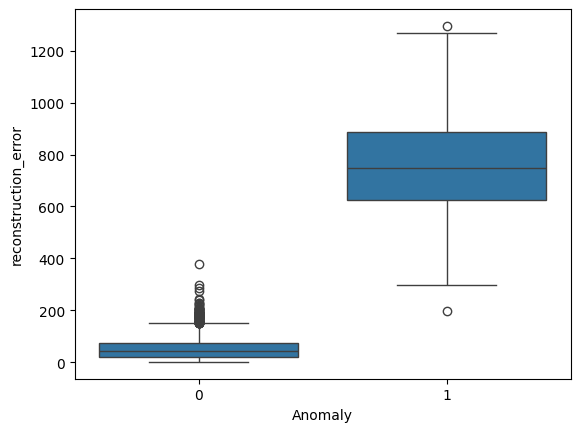

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

df = X.copy()
df["Anomaly"] = y
sns.boxplot(x="Anomaly", y="reconstruction_error", data=df)


we splitted the data for training and validation

after training the model we used several metrics to see the accuracy(prescion recall and f1 score) used the random search to find the best param to train the model but it gave poor results, so we tried to tuned them manually


used the confusion matrix to see the predictions